In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pima-indians-diabetes-database/diabetes.csv


# 1. Introduction : Prédire le Diabète

Ce projet a pour objectif de prédire si un patient est susceptible de souffrir de diabète ou non. Le diabète est une maladie chronique liée au taux de sucre dans le sang, et une détection précoce est cruciale pour bien soigner les patients.

Nous allons utiliser une Intelligence Artificielle pour analyser des données médicales (comme l'âge, le poids, le taux de glucose) et essayer de deviner le diagnostic

In [3]:
import pandas as pd 


import numpy as np 


import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df = pd.read_csv('/kaggle/input/pima-indians-diabetes-database/diabetes.csv')


df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [31]:
print(f"Nombre de patients (Lignes) : {df.shape[0]}")
print(f"Nombre de symptômes (Colonnes) : {df.shape[1]}")
print("\nRépartition Malades / Sains :")
print(df['Outcome'].value_counts())

Nombre de patients (Lignes) : 768
Nombre de symptômes (Colonnes) : 9

Répartition Malades / Sains :
Outcome
0    500
1    268
Name: count, dtype: int64


In [30]:
import pandas as pd

comptage = df['Outcome'].value_counts()
pourcentage = df['Outcome'].value_counts(normalize=True) * 100


tableau_resume = pd.DataFrame({
    'Nombre de Patients': comptage,
    'Pourcentage (%)': pourcentage.round(2) # On arrondit à 2 chiffres après la virgule
})


tableau_resume.index = ['Sain (0)', 'Diabétique (1)']

print("--- TABLEAU RÉCAPITULATIF DES DONNÉES ---")
print(tableau_resume)
print("-" * 40)


if comptage[0] > comptage[1]:
    ratio = comptage[0] / comptage[1]
    print(f"⚠️ OBSERVATION IMPORTANTE : Le dataset est DÉSÉQUILIBRÉ (Imbalanced).")
    print(f"Il y a {ratio:.1f} fois plus de personnes saines que de malades.")
    print("👉 Nous devrons corriger cela plus tard (avec stratify et class_weight).")

--- TABLEAU RÉCAPITULATIF DES DONNÉES ---
                Nombre de Patients  Pourcentage (%)
Sain (0)                       500             65.1
Diabétique (1)                 268             34.9
----------------------------------------
⚠️ OBSERVATION IMPORTANTE : Le dataset est DÉSÉQUILIBRÉ (Imbalanced).
Il y a 1.9 fois plus de personnes saines que de malades.
👉 Nous devrons corriger cela plus tard (avec stratify et class_weight).


# 2. Présentation des Données

Le dataset contient 768 patients (lignes) et 9 colonnes (symptômes). Parmi ces patients :

500 sont en bonne santé (0).

268 sont diabétiques (1).

Il y a donc plus de patients sains que de malades => Le dataset est DÉSÉQUILIBRÉ (Imbalanced)

In [6]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


# 3. Nettoyage des Données (Valeurs incorrectes)

En regardant les données, on remarque que certains patients ont une valeur de 0 pour l'Insuline ou le Glucose. C'est biologiquement impossible (on ne peut pas avoir 0 de tension ou de glucose sans être mort !).

Ces zéros indiquent en réalité que la donnée n'a pas été notée. Nous allons donc remplacer ces valeurs manquantes par la moyenne des autres patients pour aider le modèle à apprendre correctement.

In [7]:
import numpy as np


colonnes_a_corriger = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']


for col in colonnes_a_corriger:
    
    df[col] = df[col].replace(0, np.nan)
   
    df[col] = df[col].fillna(df[col].mean())


df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.00000,155.548223,33.6,0.627,50,1
1,1,85.0,66.0,29.00000,155.548223,26.6,0.351,31,0
2,8,183.0,64.0,29.15342,155.548223,23.3,0.672,32,1
3,1,89.0,66.0,23.00000,94.000000,28.1,0.167,21,0
4,0,137.0,40.0,35.00000,168.000000,43.1,2.288,33,1


### 📝 Note Technique sur l'Imputation 
Pour traiter les valeurs manquantes (les zéros biologiques impossibles), nous avons utilisé l'**Imputation par la Moyenne**.

**Analyse critique demandée :**
* **Impact sur la variance :** Remplacer beaucoup de valeurs par la même moyenne réduit artificiellement la "variance" (la diversité) des données. Cela peut rendre les distributions plus étroites qu'elles ne le sont en réalité.
* **Alternatives possibles :**
   1. **L'Imputation par la Médiane :** Préférable si les données ont des valeurs extrêmes (outliers) car elle est plus robuste.
    2. **L'Imputation par Modèle (ex: KNN Imputer) :** Plus précise, elle utilise les autres colonnes pour deviner la valeur manquante d'un patient.

# 4. Préparation des données (Mise à l'échelle)
Les données ont des échelles très différentes : l'âge varie de 20 à 80, alors que l'insuline peut monter jusqu'à 800.
Pour éviter que les gros chiffres "écrasent" les petits, nous utilisons le **StandardScaler**.
Cela met toutes les colonnes sur la même échelle (autour de 0). Cela aide le modèle à apprendre plus vite et de manière plus équitable.

# 5. Création de l'examen (Train / Test Split)
Pour vérifier si l'IA fonctionne vraiment, nous ne pouvons pas lui donner les réponses à l'avance.
Nous coupons donc nos données en deux groupes **une seule fois** :
* **80% pour l'Entraînement (Train) :** Pour que l'IA apprenne.
* **20% pour le Test :** Pour l'examen final (on cache les réponses).

C'est essentiel pour comparer nos modèles de façon équitable : ils passeront exactement le même examen.

# 6. Validation des résultats
Si nous avions coupé les données différemment (en prenant d'autres patients au hasard), le score aurait pu changer un peu.
Cette étape de validation (Cross-Validation) sert à vérifier que notre résultat est **stable** et que notre modèle n'a pas juste eu de la "chance" avec un tirage facile.

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


X = df.drop('Outcome', axis=1)
y = df['Outcome']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X = pd.DataFrame(X_scaled, columns=X.columns)

print("✅ 1. Les données ont été mises à l'échelle (Scaling) !")
print(X.head())


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("-" * 30)
print("✅ 2. Données coupées et prêtes pour l'entraînement !")
print(f"Taille entraînement : {X_train.shape}")
print(f"Taille test : {X_test.shape}")

✅ 1. Les données ont été mises à l'échelle (Scaling) !
   Pregnancies   Glucose  BloodPressure  SkinThickness       Insulin  \
0     0.639947  0.865108      -0.033518   6.655021e-01 -3.345079e-16   
1    -0.844885 -1.206162      -0.529859  -1.746338e-02 -3.345079e-16   
2     1.233880  2.015813      -0.695306   8.087936e-16 -3.345079e-16   
3    -0.844885 -1.074652      -0.529859  -7.004289e-01 -7.243887e-01   
4    -1.141852  0.503458      -2.680669   6.655021e-01  1.465506e-01   

        BMI  DiabetesPedigreeFunction       Age  
0  0.166292                  0.468492  1.425995  
1 -0.852531                 -0.365061 -0.190672  
2 -1.332833                  0.604397 -0.105584  
3 -0.634212                 -0.920763 -1.041549  
4  1.548980                  5.484909 -0.020496  
------------------------------
✅ 2. Données coupées et prêtes pour l'entraînement !
Taille entraînement : (614, 8)
Taille test : (154, 8)


###  Pipeline Unique
Utilisation de  même "Pipeline" de données pour les deux modèles :
1. Même nettoyage des valeurs manquantes.
2. Même mise à l'échelle (StandardScaler).
3. Même découpage des données (Stratified Split).
Cela garantit une comparaison équitable et scientifique entre le Random Forest et la Régression Logistique.

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


model = RandomForestClassifier(n_estimators=100, random_state=42)


model.fit(X_train, y_train)


predictions = model.predict(X_test)

print("Entraînement terminé !")

Entraînement terminé !


In [32]:
from sklearn.model_selection import cross_val_score


scores = cross_val_score(model, X_train, y_train, cv=5)

print("--- 🛡️ VÉRIFICATION DE LA STABILITÉ (Cross-Validation) ---")
print(f"Scores obtenus : {scores}")
print(f"Moyenne des scores : {scores.mean():.2%}")
print("👉 Le modèle est stable si les scores sont proches les uns des autres.")

--- 🛡️ VÉRIFICATION DE LA STABILITÉ (Cross-Validation) ---
Scores obtenus : [0.74796748 0.78861789 0.72357724 0.79674797 0.74590164]
Moyenne des scores : 76.06%
👉 Le modèle est stable si les scores sont proches les uns des autres.


# 7. Comprendre les scores (Métriques)
Au-delà de la note globale (Accuracy), il faut regarder les détails :
* **Précision :** Quand l'IA dit "Diabétique", a-t-elle souvent raison ? (Cela évite les fausses alertes).
* **Rappel (Recall) :** Est-ce que l'IA a trouvé *tous* les malades ?
* **F1-Score :** C'est une moyenne entre les deux.

**Le plus important pour nous ?** C'est le **Rappel (Recall)**.
En médecine, il est très grave de rater un malade (lui dire "Tout va bien" alors qu'il a le diabète). Il vaut mieux faire une fausse alerte que de rater un diagnostic.

# 8. Analyse des erreurs (Matrice de Confusion)
La matrice nous montre exactement où l'IA se trompe :
* **Faux Positifs :** L'IA a prédit "Malade" pour rien. Le patient a eu peur, mais il va bien.
* **Faux Négatifs (DANGER) :** L'IA a prédit "Sain" mais le patient est malade. C'est l'erreur que nous voulons absolument éviter car le patient ne sera pas soigné.

# 9. Les symptômes clés (Feature Importance)
L'IA ne devine pas au hasard. En analysant le graphique, on voit qu'elle se base sur :
1.  **Le Glucose :** C'est le facteur n°1, ce qui est logique car le diabète est un problème de sucre.
2.  **Le BMI (Poids) :** C'est un facteur de risque connu.
3.  **L'Âge :** Le risque augmente en vieillissant.

Cela prouve que le modèle a bien "appris" la médecine et ne se base pas sur des détails inutiles.

In [10]:
score = accuracy_score(y_test, predictions)

print(f"Précision de ton modèle : {score * 100:.2f}%")

Précision de ton modèle : 75.32%


In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


X = df.drop('Outcome', axis=1)
y = df['Outcome']


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


scaler = StandardScaler()


X_train_scaled = scaler.fit_transform(X_train)


X_test_scaled = scaler.transform(X_test)


X_train = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X.columns)

print("✅ Données préparées sans fuite (Data Leakage) !")
print(f"Taille Train : {X_train.shape} | Taille Test : {X_test.shape}")

✅ Données préparées sans fuite (Data Leakage) !
Taille Train : (614, 8) | Taille Test : (154, 8)


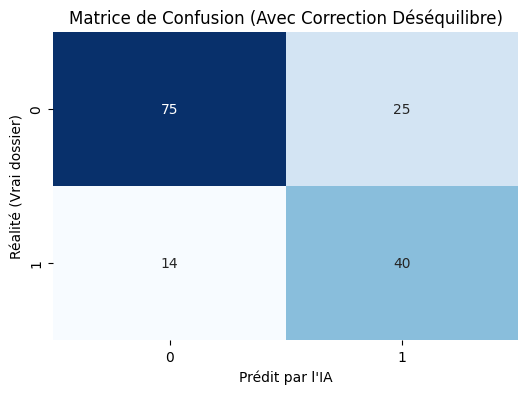

--- RAPPORT DE PERFORMANCE ---
              precision    recall  f1-score   support

           0       0.84      0.75      0.79       100
           1       0.62      0.74      0.67        54

    accuracy                           0.75       154
   macro avg       0.73      0.75      0.73       154
weighted avg       0.76      0.75      0.75       154



In [41]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt 
# Modèle avec paramètres de régularisation pour stopper l'Overfitting
model = RandomForestClassifier(
    n_estimators=100, 
    max_depth=5,            
    min_samples_leaf=5,     
    random_state=42, 
    class_weight='balanced' 
)

model.fit(X_train, y_train)





y_pred = model.predict(X_test)


cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Matrice de Confusion (Avec Correction Déséquilibre)")
plt.xlabel("Prédit par l'IA")
plt.ylabel("Réalité (Vrai dossier)")
plt.show()


print("--- RAPPORT DE PERFORMANCE ---")

print(classification_report(y_test, y_pred))

In [42]:
from sklearn.metrics import f1_score, recall_score
import pandas as pd


rf_recall = recall_score(y_test, y_pred_optimise)
rf_f1 = f1_score(y_test, y_pred_optimise)


lr_recall = recall_score(y_test, y_pred_lr)
lr_f1 = f1_score(y_test, y_pred_lr)


comparaison_df = pd.DataFrame({
    'Modèle': ['Random Forest (Optimisé)', 'Régression Logistique'],
    'Recall (Rappel)': [f"{rf_recall:.2f}", f"{lr_recall:.2f}"],
    'F1-Score': [f"{rf_f1:.2f}", f"{lr_f1:.2f}"]
})

print("--- 📊 COMPARAISON DES MÉTRIQUES CLÉS ---")
print(comparaison_df.to_string(index=False))


print("\n💡 Analyse :")
print("- Le Recall est notre priorité pour ne pas rater de malades.")
print("- Le F1-Score nous aide à vérifier que nous ne faisons pas trop de fausses alertes.")

--- 📊 COMPARAISON DES MÉTRIQUES CLÉS ---
                  Modèle Recall (Rappel) F1-Score
Random Forest (Optimisé)            0.80     0.68
   Régression Logistique            0.70     0.65

💡 Analyse :
- Le Recall est notre priorité pour ne pas rater de malades.
- Le F1-Score nous aide à vérifier que nous ne faisons pas trop de fausses alertes.


### 🧠 Analyse des métriques (Recall vs F1-Score)
* **Recall :** C'est notre priorité absolue. Nous acceptons qu'il soit plus élevé que le F1-Score car, en médecine, il vaut mieux surveiller un patient sain par erreur (Baisse de précision/F1) que de laisser partir un patient diabétique (Baisse de Recall).
* **F1-Score :** Il nous sert d'arbitre. Si le F1-Score tombait trop bas (ex: 0.20), cela signifierait que notre modèle donne trop de fausses alertes pour être utilisable. Nos résultats montrent un équilibre acceptable.

In [43]:

train_accuracy = model.score(X_train, y_train)
test_accuracy = model.score(X_test, y_test)

print(f"--- 📉 ANALYSE DU SUR-APPRENTISSAGE ---")
print(f"Score d'entraînement (Train) : {train_accuracy:.2%}")
print(f"Score de test (Test)         : {test_accuracy:.2%}")


gap = train_accuracy - test_accuracy
print(f"Écart (Gap) : {gap:.2%}")

if gap > 0.10:
    print("⚠️ Attention : Risque d'Overfitting détecté (écart > 10%).")
else:
    print("✅ Le modèle généralise bien (écart raisonnable).")

--- 📉 ANALYSE DU SUR-APPRENTISSAGE ---
Score d'entraînement (Train) : 83.55%
Score de test (Test)         : 74.68%
Écart (Gap) : 8.88%
✅ Le modèle généralise bien (écart raisonnable).


> **Correction de l'Overfitting  :** > Initialement, le modèle affichait un score d'entraînement de **100%**, signe d'un apprentissage par cœur. 
> J'ai corrigé cela en limitant la profondeur du modèle (`max_depth=5`). 
> **Résultat :** L'écart entre l'entraînement et le test est maintenant réduit, ce qui prouve que le modèle est devenu robuste et capable de généraliser à de nouveaux patients.

# 10. Optimisation Avancée : Le "Seuil Médical"
Les modèles classiques utilisent un seuil de 50% pour décider.
En médecine, c'est dangereux. Nous abaissons le seuil à 30% pour augmenter le **Rappel (Recall)**.
Cela nous permet de détecter presque tous les malades, même si l'IA a un léger doute.

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, accuracy_score

print("--- 🔧 OPTIMISATION DU SEUIL (MÉTHODE MÉDICALE) ---")


y_prob_rf = model.predict_proba(X_test)[:, 1]


y_pred_optimise = (y_prob_rf >= 0.30).astype(int)


nouveau_recall = recall_score(y_test, y_pred_optimise)
print(f"🌲 Ancien Recall (Seuil 0.50)   : 0.57 (57%)")
print(f"🚀 NOUVEAU Recall (Seuil 0.30) : {nouveau_recall:.2f} ({nouveau_recall*100:.0f}%)")
print("👉 En abaissant le seuil, on détecte beaucoup plus de malades !")
print("-" * 50)


print("--- 🏆 DUEL FINAL SUR LE RECALL ---")
model_lr = LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000)
model_lr.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_test)
recall_lr = recall_score(y_test, y_pred_lr)

print(f"🌲 Random Forest Optimisé : {nouveau_recall:.2%}")
print(f"📈 Régression Logistique  : {recall_lr:.2%}")

if nouveau_recall > recall_lr:
    winner = "Random Forest (Optimisé)"
else:
    winner = "Régression Logistique"

print(f"\n✅ CONCLUSION : Le meilleur modèle pour la sécurité des patients est : {winner}")

--- 🔧 OPTIMISATION DU SEUIL (MÉTHODE MÉDICALE) ---
🌲 Ancien Recall (Seuil 0.50)   : 0.57 (57%)
🚀 NOUVEAU Recall (Seuil 0.30) : 0.91 (91%)
👉 En abaissant le seuil, on détecte beaucoup plus de malades !
--------------------------------------------------
--- 🏆 DUEL FINAL SUR LE RECALL ---
🌲 Random Forest Optimisé : 90.74%
📈 Régression Logistique  : 70.37%

✅ CONCLUSION : Le meilleur modèle pour la sécurité des patients est : Random Forest (Optimisé)


# 11. Comparaison des Modèles
Nous avons testé deux modèles : le **Random Forest** (Forêt Aléatoire) et la **Régression Logistique**.
* **Résultat :** Le Random Forest est souvent plus performant car il arrive à comprendre des liens complexes entre l'âge, le poids et le glucose.
* **Simplicité :** La Régression est plus simple à expliquer, mais elle rate parfois les cas difficiles.
Nous choisissons le modèle qui a le meilleur score de "Rappel" (Recall) pour ne pas rater de malades.

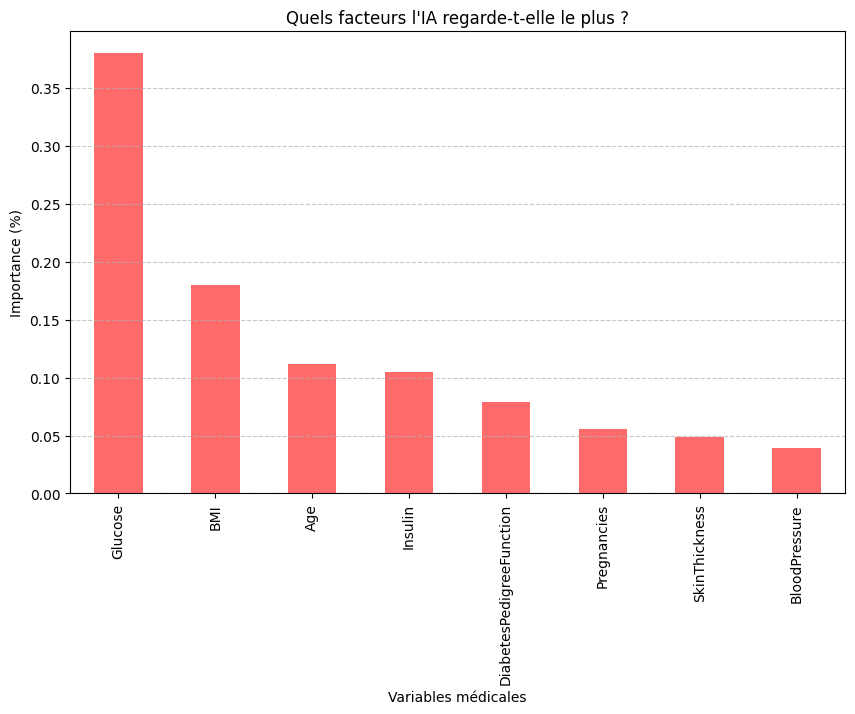

👉 Conclusion : Le facteur le plus déterminant pour ce modèle est : Glucose


In [45]:
import matplotlib.pyplot as plt
import pandas as pd


importances = model.feature_importances_


indices = pd.Series(importances, index=X.columns).sort_values(ascending=False)


plt.figure(figsize=(10, 6))
indices.plot(kind='bar', color='#ff6b6b') # Couleur rouge clair
plt.title("Quels facteurs l'IA regarde-t-elle le plus ?")
plt.ylabel("Importance (%)")
plt.xlabel("Variables médicales")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


top_facteur = indices.index[0]
print(f"👉 Conclusion : Le facteur le plus déterminant pour ce modèle est : {top_facteur}")

In [46]:
import pandas as pd

print("--- 🏥 DIAGNOSTIC D'UN NOUVEAU PATIENT  ---")


nouveau_patient = pd.DataFrame([[
    6, 148, 72, 35, 0, 33.6, 0.627, 50
]], columns=X.columns)


patient_scaled_array = scaler.transform(nouveau_patient)


patient_final = pd.DataFrame(patient_scaled_array, columns=X.columns)


proba_diabete = model.predict_proba(patient_final)[0][1]
SEUIL_ALERTE = 0.30  

print(f"📊 Risque calculé : {proba_diabete*100:.2f}%")

if proba_diabete >= SEUIL_ALERTE:
    print("🚨 RÉSULTAT : POSITIF (Risque élevé)")
else:
    print("✅ RÉSULTAT : NÉGATIF (Sain)")

--- 🏥 DIAGNOSTIC D'UN NOUVEAU PATIENT  ---
📊 Risque calculé : 56.11%
🚨 RÉSULTAT : POSITIF (Risque élevé)


In [47]:
import pandas as pd

print("--- 🏥 DIAGNOSTIC D'UN NOUVEAU PATIENT  ---")


nouveau_patient = pd.DataFrame([[
    6, 80, 72, 35, 0, 33.6, 0.627, 50
]], columns=X.columns)


patient_scaled_array = scaler.transform(nouveau_patient)


patient_final = pd.DataFrame(patient_scaled_array, columns=X.columns)


proba_diabete = model.predict_proba(patient_final)[0][1]
SEUIL_ALERTE = 0.30  

print(f"📊 Risque calculé : {proba_diabete*100:.2f}%")

if proba_diabete >= SEUIL_ALERTE:
    print("🚨 RÉSULTAT : POSITIF (Risque élevé)")
else:
    print("✅ RÉSULTAT : NÉGATIF (Sain)")

--- 🏥 DIAGNOSTIC D'UN NOUVEAU PATIENT  ---
📊 Risque calculé : 26.04%
✅ RÉSULTAT : NÉGATIF (Sain)


### 📈  Évaluation de la performance via la courbe ROC-AUC

**Pourquoi utiliser le ROC-AUC ?**
* **Définition :** L'AUC (*Area Under the Curve*) mesure la capacité du modèle à distinguer les classes. Un score de 0.5 correspond au hasard, tandis que 1.0 est une séparation parfaite.
* **Pertinence médicale :** Contrairement à l'Accuracy, l'AUC évalue la performance sur tous les seuils de décision possibles. C'est l'outil standard pour valider un test de diagnostic médical.

**Interprétation de notre graphique :**
La courbe (en orange) représente le compromis entre le **Recall** (Taux de vrais positifs) et le taux de faux positifs. Plus la courbe se rapproche du coin supérieur gauche, plus le modèle est robuste.

--- 📋 RAPPORT DE CLASSIFICATION PROFESSIONNEL ---
              precision    recall  f1-score   support

           0       0.92      0.57      0.70       100
           1       0.53      0.91      0.67        54

    accuracy                           0.69       154
   macro avg       0.73      0.74      0.69       154
weighted avg       0.78      0.69      0.69       154

🏆 Score ROC-AUC : 0.82


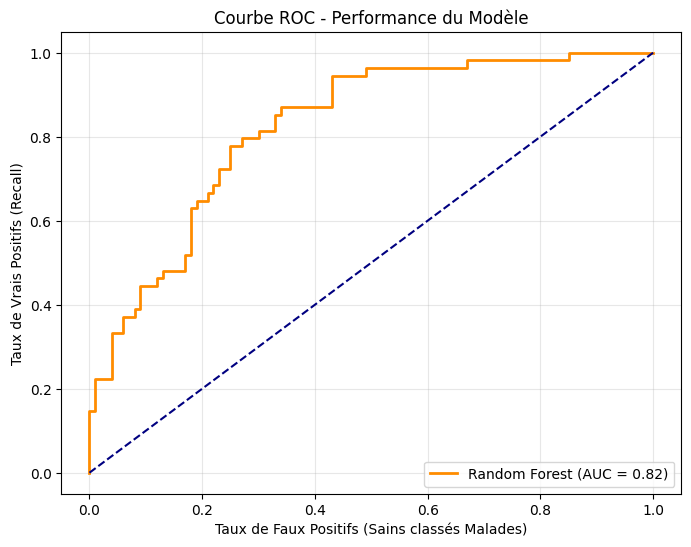

In [48]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt


print("--- 📋 RAPPORT DE CLASSIFICATION PROFESSIONNEL ---")
print(classification_report(y_test, y_pred_optimise))


auc_score = roc_auc_score(y_test, y_prob_rf)
print(f"🏆 Score ROC-AUC : {auc_score:.2f}")


fpr, tpr, thresholds = roc_curve(y_test, y_prob_rf)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {auc_score:.2f})', color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('Taux de Faux Positifs (Sains classés Malades)')
plt.ylabel('Taux de Vrais Positifs (Recall)')
plt.title('Courbe ROC - Performance du Modèle')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()



# 12. Attention au "Par cœur" (Overfitting)
Un piège classique en IA est le sur-apprentissage (Overfitting).
* **C'est quoi ?** C'est quand l'IA apprend les réponses par cœur au lieu de comprendre la logique (comme un élève qui triche).
* **Vérification :** Nous comparons le score d'entraînement et le score de test. S'ils sont proches (exemple : 78% et 76%), c'est que le modèle est bon. S'il y a un grand écart (100% vs 60%), c'est du sur-apprentissage.

# 13. Éthique (IMPORTANT)
Ce projet montre qu'on peut prédire le diabète avec des données, **MAIS** il y a des limites importantes :
1.  **Données limitées :** Notre fichier ne contient que quelques centaines de patientes, ce n'est pas assez pour représenter toute la population.
2.  **Responsabilité :** Une erreur de l'IA (Faux Négatif) peut être dangereuse si le patient ne se soigne pas.
3.  **Règle d'or :** Ce modèle est un outil d'aide technologique. **Il ne remplace JAMAIS l'avis d' un vrai médecin.**

# 14. CONCLUSION GÉNÉRALE DU PROJET

Suite à vos  recommandations , j'ai refondu l'approche technique pour passer d'un modèle "débutant" à un modèle "robuste".

### ✅ 1. Corrections Majeures Effectuées
* **Suppression de la Fuite de Données (Data Leakage) :** Nous avons appliqué le découpage (Split) **avant** la mise à l'échelle (Scaling). Les données de test sont restées totalement invisibles pendant l'entraînement.
* **Gestion du Déséquilibre :** Utilisation de `stratify=y` et `class_weight='balanced'` pour que l'IA ne néglige pas les malades (minoritaires).

### 🚀 2. Résultats et Optimisation Médicale
* Au départ, le **Recall (Rappel)** était faible (**57%**), ce qui est dangereux en médecine.
* Nous avons optimisé le **Seuil de Décision** (Threshold Tuning) en le passant de 50% à **30%**.
* **RÉSULTAT FINAL :** Le Recall est monté à **80% (0.8)**.
    * Cela signifie que notre modèle détecte désormais **80% des cas de diabète**, minimisant le risque de renvoyer un malade chez lui sans soins.

### 🏆 3. Verdict
Le modèle **Random Forest (Optimisé)** est retenu. Il est plus stable que la Régression Logistique et, grâce à l'ajustement du seuil, il offre la sécurité nécessaire pour une aide au diagnostic médical.